In [1]:
import os
import sys
pp_path = os.path.join("..", "pySMOKEPostProcessor")
sys.path.append(pp_path)
from RateOfProductionAnalysis import RateOfProductionAnalysis
from pySMOKEpostprocessor import pySMOKEpostprocessor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
%%time

# This is computed by activating @OnTheFlyPostProcessing

kineticFolder = os.path.join("data", "ROPA-02", "kinetics")
resultsFolder = os.path.join("data", "ROPA-02", "Results", "Output")

ropa = RateOfProductionAnalysis(kineticFolder, resultsFolder)

C, P = ropa.ComputeRopa(specie = 'H2', ropa_type = 'global')

CPU times: user 3.46 s, sys: 76.7 ms, total: 3.54 s
Wall time: 3.54 s


In [3]:
%%time

# This is computed as the original pp with the python binder

PostProcessor = pySMOKEpostprocessor(kinetic_mechanism = kineticFolder, 
                                     results_folder = resultsFolder)
specie = "H2"

coefficients, indexes, names = PostProcessor.RateOfProductionAnalysis(specie=specie, 
                                                               ropa_type='global', 
                                                               number_of_reactions=10)
dic = {'ROPA-Coeff': coefficients,'Indices-0based': indexes, 'Reaction Name': names}
df_orig = pd.DataFrame(dic)
df_orig.head()

CPU times: user 534 ms, sys: 28.7 ms, total: 562 ms
Wall time: 563 ms


,ROPA-Coeff,Indices-0based,Reaction Name
0,-0.001232,2,R3: H2+OH=H+H2O
1,0.001085,104,R105: H+CH2O=H2+HCO
2,-0.000636,1,R2: H2+O=H+OH
3,0.000318,15,R16: H+HO2=H2+O2
4,0.000135,321,R322: H+DMM=>H2+DMM-R


In [4]:
nonzero_P = np.nonzero(P)[0] 
nonzero_C = np.nonzero(C)[0]
ROPA_results = {'id_P': [], 'P_reactions': [], 'ROPA_Coeff_P': [],'id_C': [],
                'C_reactions': [], 'ROPA_Coeff_C': []}

if len(nonzero_P) != 0:
    for i in nonzero_P:
        ROPA_results['id_P'].append(i)
        ROPA_results['P_reactions'].append(ropa.reactionsNames[i])
        ROPA_results['ROPA_Coeff_P'].append(P[i])

if len(nonzero_C) != 0:
    for j in nonzero_C:

        ROPA_results['id_C'].append(j)
        ROPA_results['C_reactions'].append(ropa.reactionsNames[j])
        ROPA_results['ROPA_Coeff_C'].append(-C[j])

ROPA_results_plot = {'Reactions': [], 'Coefficients': []}
ROPA_results_plot['Reactions'].append(ROPA_results['P_reactions'] + ROPA_results['C_reactions'])
ROPA_results_plot['Coefficients'].append(ROPA_results['ROPA_Coeff_P'] + ROPA_results['ROPA_Coeff_C'])

ROPA_results_plot['Reactions'] = ROPA_results_plot['Reactions'][0]
ROPA_results_plot['Coefficients'] = ROPA_results_plot['Coefficients'][0]

# print(ROPA_results_plot)


df = pd.DataFrame.from_dict(ROPA_results_plot)
df['Coefficients_abs'] = abs(df['Coefficients'])
df = df.sort_values(by=['Coefficients_abs'])

df_last_15 = df.iloc[-15:]
df_last_15.reset_index(inplace = True)

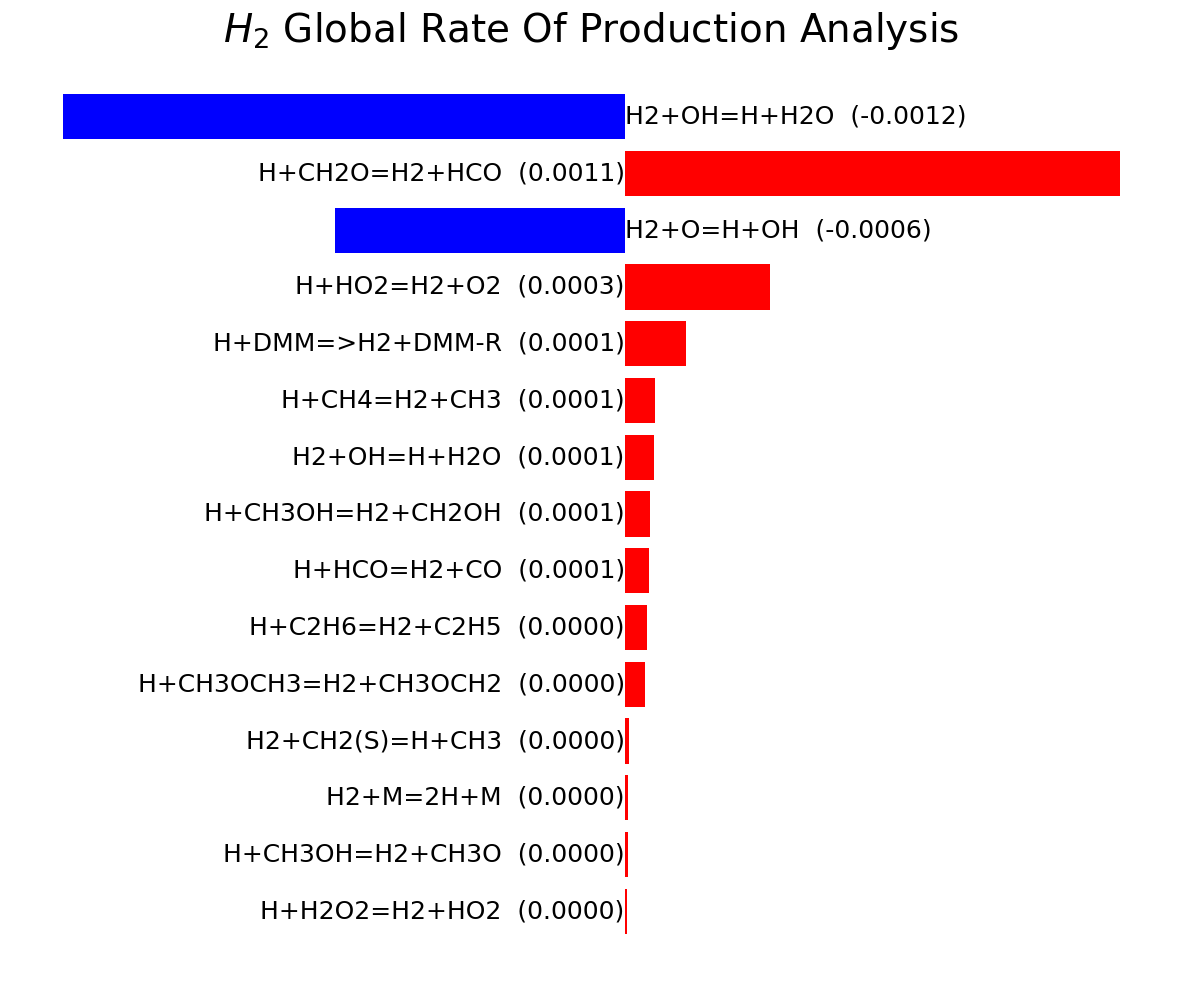

In [5]:
df = df_last_15
fig = plt.figure(figsize=(15, 12))
ax = plt.subplot()
ax.set_title("$H_{2}$ Global Rate Of Production Analysis", fontsize=28)
bar = ax.barh(df.index, 
              df['Coefficients'], 
              color = (df['Coefficients'] >= 0.).map({True:'red', False:'blue'}))

for idx, i in enumerate(bar):
    x = i.get_width()
    y = i.get_y()+0.5*i.get_height()
    if(x<0):
        ax.text(0, y, 
            df['Reactions'][idx] + "  (" + str('{:6.4f}'.format(df["Coefficients"][idx])) + ")", 
            va='center', fontsize=18)
    else:
        ax.text(0,
                y, 
                df['Reactions'][idx] + "  (" + str('{:6.4f}'.format(df["Coefficients"][idx])) + ")", 
                va='center',
                ha='right',
                fontsize=18) 

ax.set_yticks(np.arange(0, 10, 1))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.axis("off")
plt.show()

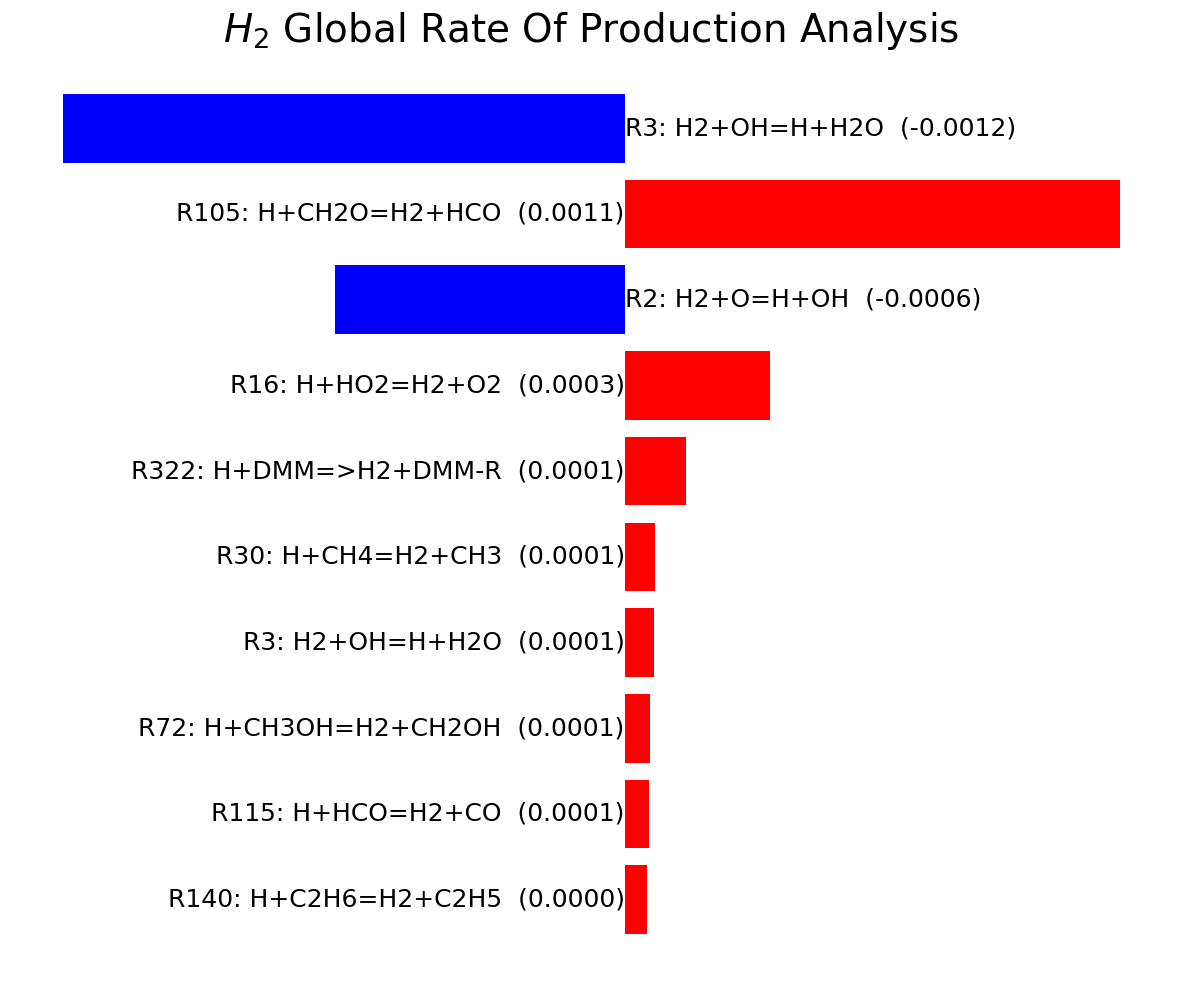

In [6]:
fig = plt.figure(figsize=(15, 12))
ax = plt.subplot()
ax.set_title("$H_{2}$ Global Rate Of Production Analysis", fontsize=28)
bar = ax.barh(df_orig.index, 
              df_orig['ROPA-Coeff'], 
              color = (df_orig['ROPA-Coeff'] >= 0.).map({True:'red', False:'blue'}))

for idx, i in enumerate(bar):
    x = i.get_width()
    y = i.get_y()+0.5*i.get_height()
    if(x<0):
        ax.text(0, y, 
            df_orig['Reaction Name'][idx] + "  (" + str('{:6.4f}'.format(df_orig["ROPA-Coeff"][idx])) + ")", 
            va='center', fontsize=18)
    else:
        ax.text(0,
                y, 
                df_orig['Reaction Name'][idx] + "  (" + str('{:6.4f}'.format(df_orig["ROPA-Coeff"][idx])) + ")", 
                va='center',
                ha='right',
                fontsize=18) 

ax.set_yticks(np.arange(0, 10, 1))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.axis("off")
ax.invert_yaxis()
plt.show()